# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [12]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [13]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [14]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [15]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [16]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0.)

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [17]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [18]:
save_plot_flag      = False
load_models_flag    = True

In [19]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'

In [20]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [21]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [22]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [23]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [24]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Discard minor features.

In [25]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [26]:
seed                                = 42

---

### Load models

In [27]:
if load_models_flag:
    AGN_gal_clf   = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')
    radio_det_clf = pyc.load_model('models/classification_radio_detect_may_09_2022')
    redshift_reg  = pyr.load_model('models/regression_z_may_10_2022')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [28]:
threshold_AGN   = 0.5
threshold_radio = 0.5

In [29]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_0': 'Score_gal', 'Score_1': 'Score_AGN'})

In [30]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})

In [31]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})

Obtain intermediate metrics

In [32]:
filter_AGN_t       = np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_gal_AGN_t   = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_AGN_p       = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN)
filter_radio_p     = np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)
filter_radio_AGN_p = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN) & np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)

In [33]:
cm_AGN = np.array([[np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df['class'] == 0) & np.array(full_catalog_df['pred_class'] == 1))],\
                   [np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df['class'] == 1) & np.array(full_catalog_df['pred_class'] == 1))]])

In [34]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio'] == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio'] == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio'] == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio'] == 1))]])

In [35]:
cm_radio_gal_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 0) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio'] == 0)),\
                              np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 0) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio'] == 1))],\
                             [np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 1) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio'] == 0)),\
                              np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 1) &\
                                     np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio'] == 1))]])

In [36]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

In [37]:
sigma_mad_field_gal_AGN    = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
sigma_nmad_field_gal_AGN   = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
sigma_z_field_gal_AGN      = sigma_z(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
sigma_z_norm_field_gal_AGN = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t & filter_gal_AGN_t, 'Z'], full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])
out_frac_field_gal_AGN     = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p & filter_gal_AGN_t, 'pred_Z'])

Plot histograms for scores.

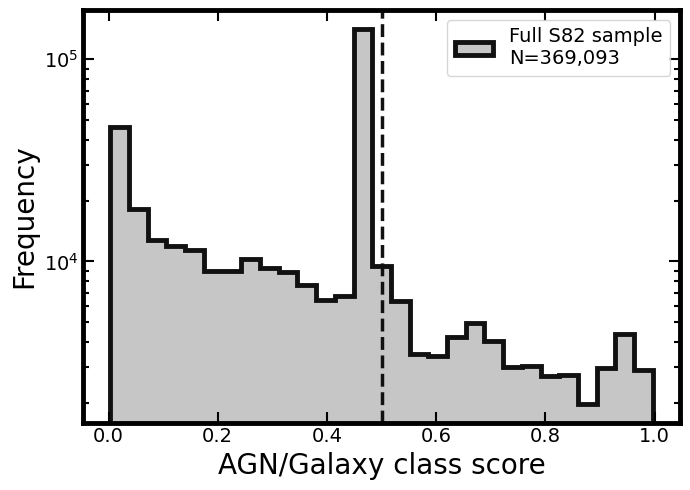

In [38]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(full_catalog_df.loc[:, 'Score_AGN']))

ax1.hist(full_catalog_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Full {used_area} sample\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/predicted_AGN_scores_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

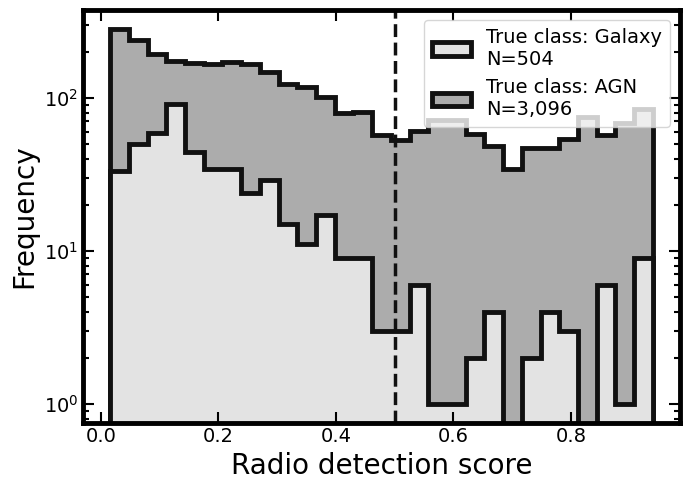

In [39]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=1.0, label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=1)
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=1.0, label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=0)

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/predicted_radio_scores_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

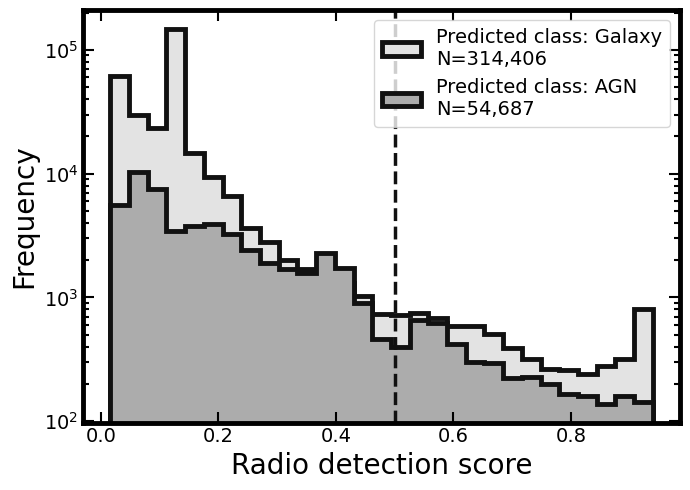

In [40]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN), 'Score_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=1.0, label=f'Predicted class: Galaxy\nN={sample_size_gal:,}')
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN), 'Score_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=1.0, label=f'Predicted class: AGN\nN={sample_size_AGN:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/predicted_radio_scores_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

### Select sources predicted to be Radio AGN

In [41]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
total_size              = len(full_catalog_df)
num_AGN_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1))
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [42]:
filter_radio_AGN_p_full = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN) & np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)
num_AGN_p_full          = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN))
num_gal_p_full          = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN))
num_radio_p_full        = np.sum(np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio))
num_radio_AGN_p_full    = np.sum(filter_radio_AGN_p_full)

In [43]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_t]

In [44]:
filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN) & np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio)
num_AGN_p               = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] > threshold_AGN))
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'Score_AGN'] <= threshold_AGN))
num_radio_p             = np.sum(np.array(full_catalog_df.loc[:, 'Score_radio'] > threshold_radio))
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

In [45]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_p]

Add individual metrics for redshift

In [46]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [47]:
str_0_t   = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t   = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t   = f'{num_AGN_t:,} are confirmed to be AGN. And, from the AGN,\n'
str_3_t   = f'{num_radio_AGN_t:,} are detected in radio.'

str_0_p_f = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_p_f = f'{num_gal_p_full:,} are predicted to be galaxies. On the other side,\n'
str_2_p_f = f'{num_AGN_p_full:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p_f = f'{num_radio_AGN_p_full:,} are predicted to be detected in radio.'

str_0_p   = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p   = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p   = f'{num_AGN_p:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p   = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

In [48]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p_f + str_1_p_f + str_2_p_f + str_3_p_f)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)

------------------------------------------------------------
Out of 369,093 initial sources in S82,
504 are confirmed to be galaxies. On the other side,
3,096 are confirmed to be AGN. And, from the AGN,
1,163 are detected in radio.
------------------------------------------------------------
Out of 369,093 initial sources in S82,
314,406 are predicted to be galaxies. On the other side,
54,687 are predicted to be AGN. And, from the predicted AGN,
4,049 are predicted to be detected in radio.
------------------------------------------------------------
Out of 1,163 initial radio-detected AGN in S82,
243 are predicted to be galaxies. On the other side,
920 are predicted to be AGN. And, from the predicted AGN,
474 are predicted to be detected in radio.
------------------------------------------------------------


In [49]:
cols_4_table = show_columns = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z', 'Delta_z_N']

In [50]:
display(full_catalog_df.loc[:, cols_4_table].sort_values(by='pred_Z', ascending=False).head(20))

,RA_ICRS,DE_ICRS,Name,TYPE,band_num,class,pred_class,radio_detect,pred_radio,Z,pred_Z,Delta_z_N
346972,30.274347,-0.333221,J020105.83-001959.5,QR,11,1.0,1,1,1,2.806,2.505831,-0.079
350551,346.598785,-0.769825,J230623.70-004611.3,QR,11,1.0,1,1,1,3.588,2.474994,-0.243
220408,28.751797,1.100096,J015500.42+010600.3,QR,11,1.0,1,1,1,2.555,2.452675,-0.029
250497,34.369316,-0.874197,J021728.63-005227.0,QRX,11,1.0,1,1,1,2.457,2.414569,-0.012
250457,339.681549,0.279982,J223843.56+001647.9,QR,11,1.0,1,1,1,3.448,2.390023,-0.238
91785,341.345123,-0.981612,J224522.82-005853.7,QR,11,1.0,1,1,1,2.134,2.387261,0.081
356803,331.784698,1.023693,J220708.32+010125.3,QR,11,1.0,1,1,1,2.911,2.328294,-0.149
262137,29.582396,-0.206112,J015819.76-001221.9,Q,11,1.0,1,1,1,3.286,2.311127,-0.227
353451,34.023491,-1.300883,J021605.63-011803.1,QR,11,1.0,1,1,1,2.803,2.302469,-0.132
75352,11.183654,0.217644,J004444.07+001303.5,QR,11,1.0,1,1,1,2.280,2.226650,-0.016


Confusion matrix for AGN/galaxy prediction on all sources

In [51]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

Confusion matrix for radio detection prediction on all predicted AGN

In [52]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

Confusion matrix for radio detection prediction on all confirmed AGN and galaxies that are predicted to be AGN

In [53]:
MCC_radio_gal_AGN    = MCC_from_CM(cm_radio_gal_AGN)
ACC_radio_gal_AGN    = ACC_from_CM(cm_radio_gal_AGN)
F1_radio_gal_AGN     = F1_from_CM(cm_radio_gal_AGN)
Recall_radio_gal_AGN = Recall_from_CM(cm_radio_gal_AGN)

In [54]:
# sigma_mad_field    = sigma_mad(full_catalog_df.loc[:, 'Z'],    full_catalog_df.loc[:, 'pred_Z'])
# sigma_nmad_field   = sigma_nmad(full_catalog_df.loc[:, 'Z'],   full_catalog_df.loc[:, 'pred_Z'])
# sigma_z_field      = sigma_z(full_catalog_df.loc[:, 'Z'],      full_catalog_df.loc[:, 'pred_Z'])
# sigma_z_norm_field = sigma_z_norm(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'])
# out_frac_field     = outlier_frac(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'])

Print metrics

In [55]:
print('Metrics for AGN prediction on all sources')
print(f'Matthews Correlation Coefficient, MCC = {MCC_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_AGN:.4f}')

Metrics for AGN prediction on all sources
Matthews Correlation Coefficient, MCC = 0.5794
Accuracy,                         ACC = 0.8494
F-1 Score,                         F1 = 0.9059
Recall,                        Recall = 0.8430


In [56]:
print('Metrics for radio detection prediction on all predicted AGN')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio:.4f}')
print(f'Recall,                        Recall = {Recall_radio:.4f}')

Metrics for radio detection prediction on all predicted AGN
Matthews Correlation Coefficient, MCC = 0.2935
Accuracy,                         ACC = 0.9053
F-1 Score,                         F1 = 0.3444
Recall,                        Recall = 0.3531


In [57]:
print('Metrics for radio detection prediction on all confirmed AGN and galaxies that are predicted to be AGN')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_gal_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_gal_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_gal_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_radio_gal_AGN:.4f}')

Metrics for radio detection prediction on all confirmed AGN and galaxies that are predicted to be AGN
Matthews Correlation Coefficient, MCC = 0.4026
Accuracy,                         ACC = 0.7401
F-1 Score,                         F1 = 0.5803
Recall,                        Recall = 0.5162


In [58]:
print('Metrics for redshift prediction on all predicted radio AGN')
print(f'Sigma MAD                             = {sigma_mad_field:.4f}')
print(f'Sigma NMAD,                           = {sigma_nmad_field:.4f}')
print(f'Sigma z,                              = {sigma_z_field:.4f}')
print(f'Sigma z normalized,                   = {sigma_z_norm_field:.4f}')
print(f'Outlier fraction,                     = {out_frac_field:.4f}')

Metrics for redshift prediction on all predicted radio AGN
Sigma MAD                             = 0.1743
Sigma NMAD,                           = 0.0957
Sigma z,                              = 0.1923
Sigma z normalized,                   = 0.0896
Outlier fraction,                     = 0.2426


In [59]:
print('Metrics for redshift prediction on all confirmed AGN and galaxies that are predicted to be radio AGN')
print(f'Sigma MAD                             = {sigma_mad_field_gal_AGN:.4f}')
print(f'Sigma NMAD,                           = {sigma_nmad_field_gal_AGN:.4f}')
print(f'Sigma z,                              = {sigma_z_field_gal_AGN:.4f}')
print(f'Sigma z normalized,                   = {sigma_z_norm_field_gal_AGN:.4f}')
print(f'Outlier fraction,                     = {out_frac_field_gal_AGN:.4f}')

Metrics for redshift prediction on all confirmed AGN and galaxies that are predicted to be radio AGN
Sigma MAD                             = 0.1734
Sigma NMAD,                           = 0.0952
Sigma z,                              = 0.4475
Sigma z normalized,                   = 0.1962
Outlier fraction,                     = 0.2397


Plot predictions

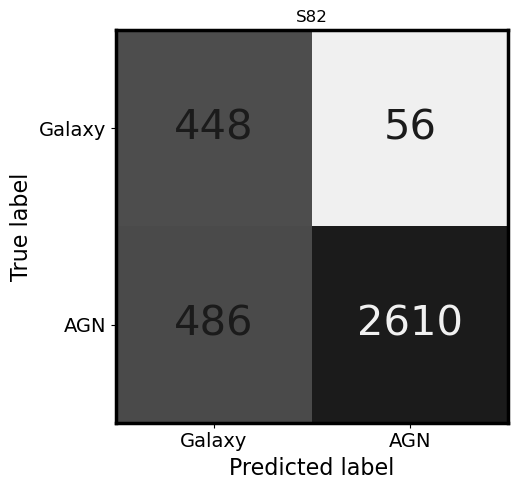

In [60]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

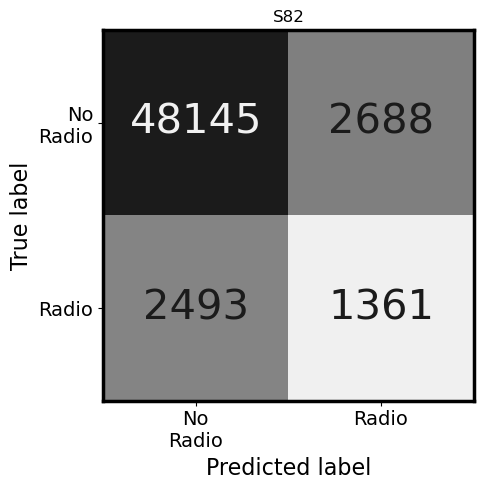

In [61]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

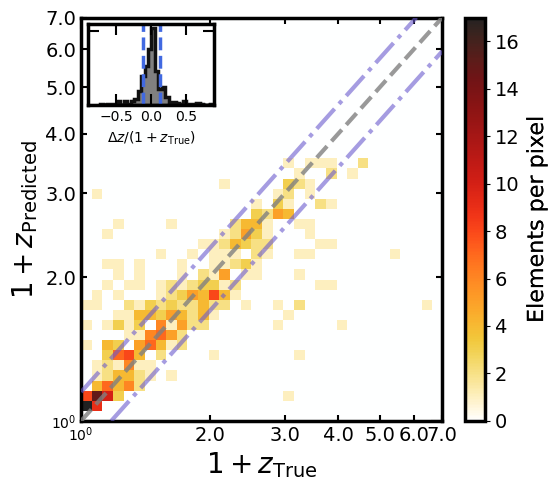

In [62]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()